# NLP Project Work: Natural Language Inference Task 
Andrea Alfonsi, Gianluca Di Tuccio, Lorenzo Orsini<br><br>
In this project work we performed a Natural Language Inference task on the dataset proposed for the [SemEval 2023 Task 4:Identification of Human Values behind Arguments](https://zenodo.org/record/7402070#.Y7Vb-nbMJPY).
Here, we have for each argument a premise, a conclusion and a stance, which can have the two values 'against' or 'in favour of' according to the pair premise-conclusion. For example, with the premise "the security of children and teachers is essential for all." and the conclusion "we should adopt a zero-tolerance policy in schools.", the stance is "in favor of".<br>
This NLI task aims to produce the right stance for a given premise-conclusion pair. To do so, we implemented three fine-tuned models: BERT-large, XLNet-large and a Siamese BERT-NLI-large. In the end, the best F1-score was reached with XLNet-large, with a performance of 0.93.<br>
You can find more details on this project and steps in the PDF report. Also, some parts are taken from the previous notebook (i.e. HVM Standard Project).
This notebook is organized as follows:
- chapter 1: import useful libraries and load the data;
- chapter 2: statistics of data;
- chapter 3: NLI task with XLNet-large;
- chapter 4: NLI task with BERT-large;
- chapter 5: NLI task with Siamese Bert-Network.

At the end of the notebook, it is possible to find the sitography and bibliography.

In [1]:
%%capture
!pip install transformers==4.18.0
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/DitucSpa/Human-Values-Detection

Cloning into 'Human-Values-Detection'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 36 (delta 9), reused 29 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.


## 1. Import useful libraries and data

Here we import the libraries used in this notebook:

In [3]:
# torch and transformers imports
from datasets import Dataset
import torch
from torch import nn
import torch.optim as optim
import transformers
from transformers import AdamW, Trainer, AutoTokenizer, XLNetForSequenceClassification, TrainingArguments, get_constant_schedule, get_cosine_schedule_with_warmup, EvalPrediction,BertForSequenceClassification, BertModel


# other stuff
import pandas as pd
import csv
import random
import os
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
import numpy as np

The following code block is used to set the seed for the notebook. For this task, we evaluated the models for three seeds (42, 2022, 1337).

In [4]:
def set_seed(number):
  torch.manual_seed(number)
  torch.cuda.manual_seed_all(number)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(number)
  random.seed(number)
  os.environ['PYTHONHASHSEED'] = str(number)
seed = 1337
set_seed(seed)

Now we load the data

In [5]:
# loading X_train, X_val, X_test
X_split = ['training', 'validation', 'test']
splits = ['train', 'val', 'test']
path = 'Human-Values-Detection/datasets/'
for i in range(len(splits)):
  name_file = path+'arguments-' + X_split[i] + '.tsv'
  locals()["X_" + splits[i]] = pd.read_csv(name_file, sep='\t')

# loading the labels
y_split = ['training', 'validation']
for i in range(len(y_split)):
  name_file = path+'labels-' + y_split[i] + '.tsv'
  locals()["y_" + splits[i]] = pd.read_csv(name_file, sep='\t')


In [6]:
X_train.head()

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


Let's see how many instances for each split:


In [7]:
# see how many instances for each split
train_shape = X_train.shape[0]
print('Number of arguments for training split: \t{0} '.format(train_shape))

val_shape = X_val.shape[0]
print('Number of arguments for validation split: \t{0} '.format(val_shape))

test_shape = X_test.shape[0]
print('Number of arguments for test split: \t\t{0} '.format(test_shape))

n_labels = y_train.shape[1]-1
print('Number of labels for this task: \t\t{0} '.format(n_labels))


Number of arguments for training split: 	5393 
Number of arguments for validation split: 	1896 
Number of arguments for test split: 		1576 
Number of labels for this task: 		20 


Now we need to define a function that creates a pandas dataframe and a torch dataset with some modification from the original one. In particular, we lower all the premises and the conclusions, and we converted the english stance 'in favor of' to the american version 'in favour of': now we can assign to each stance a vector that represents its label. More specifical, we choose to assign the vector [1,0] to 'in favour of', while the vector [0,1] represent 'against'.

In [8]:
def build_dataset(X,y):
  X = X.astype("string")
  df = pd.DataFrame(columns=['Premise', 'Conclusion', 'Stance'])
  X['Premise'] = X['Premise'].apply(lambda x: x.lower() + '.' if x[-1]!='.' else x.lower())
  X['Conclusion'] = X['Conclusion'].apply(lambda x: x.lower() + '.' if x[-1]!='.' else x.lower())
  X['Stance'] = X['Stance'].apply(lambda x: 'in favour of' if x=='in favor of' else x)
  df['Premise+Conclusion'] = X['Premise'] + X['Conclusion']
  df['Stance'] = X['Stance'].str.lower()
  df['labels'] = df['Stance'].apply(lambda y: [1.,0.] if y == 'in favour of' else [0.,1.])
  df['Conclusion'] = X['Conclusion']
  df['Premise'] = X['Premise']
  df = df.sample(frac=1, random_state=seed)
  dataset = Dataset.from_pandas(df)
  return df, dataset

In [9]:
df_train, ds_train = build_dataset(X_train, y_train)
df_val, ds_val = build_dataset(X_val, y_val)

Then, we load the csv file that contains the predictions for each model (used in the ***Results*** paragraph).

In [77]:
models_results = pd.read_csv('Human-Values-Detection/csv/NLI_results.csv')

## 2. Statistics

Let's see some statistics of premise and conclusion on \training and validation data:

99 Percentile of story length is:  89


,Premise+Conclusion
count,5393.000000
mean,27.071945
std,14.756657
min,7.000000
25%,18.000000
50%,24.000000
75%,32.000000
max,140.000000


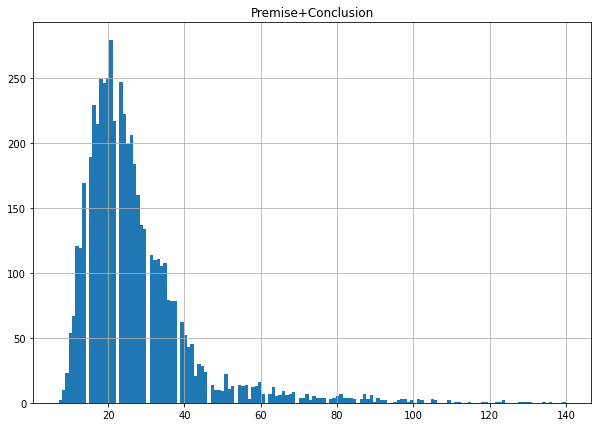

In [11]:
stat_1 = pd.DataFrame(df_train['Premise+Conclusion'].apply(lambda x: x.split(" ")).apply(len))
stat_1.hist(grid=True, bins=150, figsize=(10,7))
print('99 Percentile of story length is: ', int(stat_1.quantile(0.99)))
stat_1.describe()

Here we can see that the max value for the input premise+conclusion is above the max length of transformer models like BERT and XLNet. For this reason we choose as input length the maximum of this distribution, that allows us to avoid truncation of the input

In [12]:
input_length = int(stat_1.max())

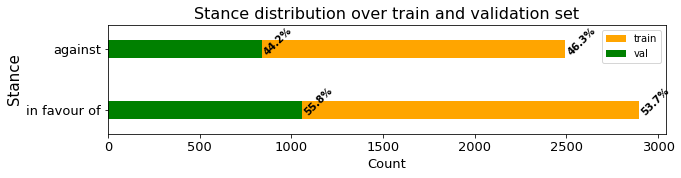

In [13]:
df_train.Stance.value_counts().plot(kind='barh', figsize=(10,2), label = 'train', color = 'orange', fontsize = 13, width = 0.3)
df_val.Stance.value_counts().plot(kind='barh', figsize=(10,2), label = 'val', color = 'green', fontsize = 13, width = 0.3)
train_tot = df_train.shape[0]
val_tot = df_val.shape[0]

for i, v in enumerate([df_train['Stance'].value_counts().iloc[0], df_train['Stance'].value_counts().iloc[1]]):
    plt.text(v+2.2, i-0.1, str(round(v*100/train_tot,1))+'%', color='black', fontweight='bold', rotation = 45)
for i, v in enumerate([df_val['Stance'].value_counts().iloc[0], df_val['Stance'].value_counts().iloc[1]]):
    plt.text(v+2.2, i-0.1, str(round(v*100/val_tot,1))+'%', color='black', fontweight='bold', rotation = 45)
plt.title('Stance distribution over train and validation set', fontsize=16)
plt.ylabel('Stance', fontsize = 15)
plt.xlabel('Count', fontsize = 13)
plt.xticks(rotation = 0)
plt.legend(fontsize = 10)

As we can see for both splits the stance 'in favour of' is more frequent than 'against': in the training set the difference is about 7%, while for the validation set of 11%. Comparing each stance between training and validation set, we can see that there is a little difference (2%) for both labels.

## 3. XLNet Large

Let's now use XLNet-large for our NLI task. First of all, we need to import the pretrained model and its tokenizer:

In [ ]:
model_name = 'xlnet-large-cased'

# Max length of the input is set to the max defined before
max_length = input_length

# Load the Transformers XLNet-large pretrained model
transformer_model = XLNetForSequenceClassification.from_pretrained(model_name, output_hidden_states = False, num_attention_heads=16, num_hidden_layers=24)

Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-large-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-large-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

To reduce the overfitting during the training, we modify the classification head of the original model, setting to 0.3 the dropout rate of the two dense layers.

In [ ]:
transformer_model.logits_proj = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(1024, 8),
    nn.ReLU(True),
    nn.Dropout(0.3),
    nn.Linear(8, 2),
)

Now we re-initialize the the last layers of the network, to stabilize the fine-tuning process (as explained in the report). We have tuned the number of layers to re-initialize on the validation set, finding the best number with 6:

In [ ]:
reinit_layers = 6

if reinit_layers > 0:
    print(f'Reinitializing Last {reinit_layers} Layers ...')
    encoder_temp = getattr(transformer_model, 'transformer')
    for layer in encoder_temp.layer[-reinit_layers:]:
        for module in layer.modules():
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean = 0.0, std = transformer_model.config.initializer_range)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=transformer_model.config.initializer_range)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)
    print('Done.!')

Reinitializing Last 6 Layers ...
Done.!


Now we define the tokenizer for this model:

In [ ]:
def load_tokenizer(name):
  tokenizer = AutoTokenizer.from_pretrained(name)
  # we use CLS also for BOS, and SEP for EOS
  tokenizer.bos_token = tokenizer.cls_token
  tokenizer.eos_token = tokenizer.sep_token
  print('Tokenizer: {0}, Special Token used: {1}, {2}'.format(name, tokenizer.bos_token, tokenizer.eos_token))
  return tokenizer

tokenizer_xlnet = load_tokenizer(model_name)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Tokenizer: xlnet-large-cased, Special Token used: <cls>, <sep>


And then we tokenize the the train and validation set. To do this we define the process_data_to_model_inputs function, to tokenize both Premise and Conclusion, separated by the token <SEP>.

In [ ]:
def process_data_to_model_inputs(batch, tokenizer):
  inputs = tokenizer(batch['Premise'], batch['Conclusion'], padding="max_length", max_length=input_length, truncation=True)
  batch["input_ids"] = inputs.input_ids.copy()
  batch["attention_mask"] = inputs.attention_mask.copy()
  return inputs

In [ ]:
# Tokenization of Premise&Conclusion of the training set
train_mapped = ds_train.map(lambda x: process_data_to_model_inputs(x, tokenizer_xlnet), batched=True, batch_size = 16)
# we convert the results into torch
train_mapped.set_format(type="torch")

  0%|          | 0/338 [00:00<?, ?ba/s]

In [ ]:
print(tokenizer_xlnet.decode(train_mapped['input_ids'][3]))

<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad> an austerity regime can help lower debt throughout the country.<sep> We should adopt an austerity regime.<sep><cls>


In [ ]:
# Tokenization of Premise&Conclusion of the validation set
val_mapped = ds_val.map(lambda x: process_data_to_model_inputs(x, tokenizer_xlnet), batched=True, batch_size = 16)
# we convert the results into torch
val_mapped.set_format(type="torch")

  0%|          | 0/119 [00:00<?, ?ba/s]

Now we need to define the metric by which we'll evaluate the model performance on the validation set. Here we chose to use the macro F1-score

In [ ]:
def compute_metrics(p: EvalPrediction):
  global my_global
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  true = p.label_ids
  results = []
  preds = np.argmax(preds, axis=1)
  true = np.argmax(true, axis=1)
  return {'f1': f1_score(true,results,average='macro')}

Now we are ready to train our model. We set the batch size and the number of epochs (tuned on the validation set)

In [ ]:
batch_size = 16
epochs = 4

and then we can begin the training process:

In [ ]:
transformer_model.to("cuda")

os.environ["WANDB_DISABLED"] = "true"

# define the training arguments (eval_step, epochs, output for checkpoint, etc)
training_args = TrainingArguments(
    output_dir='./drive2/MyDrive2/NLI',
    evaluation_strategy="epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=True,
    num_train_epochs = epochs,
    weight_decay=0.01,
)

# Adam and scheduler
optimizer = AdamW(transformer_model.parameters(), lr= 2e-5)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=500,num_training_steps=batch_size*epochs)
optimizers= optimizer, scheduler

# initialize trainer

trainer = Trainer(
    model=transformer_model,
    tokenizer=tokenizer_xlnet,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_mapped,
    eval_dataset=val_mapped,
    optimizers=optimizers
)

trainer.train()

In [ ]:
from IPython.display import Image
image_url = "https://raw.githubusercontent.com/DitucSpa/Human-Values-Detection/main/img/NLI_XLNetLarge_seed42.png"
Image(url=image_url, width=400, height=170)

As we can see, the model doesn't overfit and we stop the training at the 4th epoch, when the validation loss started to get worse.

After training the model for each of the three seeds, we load the weights obtained with each seed and take as macro F1-score for XLNet-large the F1-score averaged for each seed:

In [ ]:
def generate_summary(batch, tokenizer):
    inputs = tokenizer(batch['Premise'], batch['Conclusion'], padding="max_length", truncation=True, max_length=input_length, return_attention_mask=True, return_tensors='pt')
    inputs['labels']=torch.FloatTensor(batch['labels'])
    input_ids = inputs['input_ids'].to("cuda")
    attention_mask = inputs['attention_mask'].to("cuda")
    labels = torch.FloatTensor(batch['labels']).to('cuda')
    token_type_ids = inputs['token_type_ids'].to("cuda")
    outputs = model(input_ids=input_ids,attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
    batch['outputs']=outputs[1]
    return batch

Let's compute the macro F1-score averaged on the three seeds:

In [ ]:
path = '/content/drive/MyDrive/NLP' # load the folder with the weights from the drive

res = []
for filename in os.listdir(path):
  if 'NLI_XLN' in filename:
    print(filename)
    model = torch.load("/content/drive/MyDrive/NLP/" + filename)
    model.to("cuda")
    model.eval()
    results = ds_val.map(lambda x: generate_summary(x, tokenizer_xlnet), batched=True, batch_size=16) 
    res.append(classification_report(np.argmax(results['labels'], axis = 1), np.argmax(results['outputs'], axis = 1), output_dict = True))

NLI_XLN_2022


  0%|          | 0/119 [00:00<?, ?ba/s]

NLI_XLN_42


  0%|          | 0/119 [00:00<?, ?ba/s]

NLI_XLN_1337


  0%|          | 0/119 [00:00<?, ?ba/s]

In [ ]:
F1_0 = 0 # F1 score for the class 'in favour of'
F1_1 = 0 # F1 score for the class 'against'
F1 = 0 # macro F1 score
for k in range(len(res)):
  F1_0 += res[k]['0']['f1-score']
  F1_1 += res[k]['1']['f1-score']
  F1 += res[k]['macro avg']['f1-score']
print("The F1-score for class 'in favour of' is: \t{:.2f}".format(F1_0/len(res)))
print("The F1-score for class 'against' is: \t\t{:.2f}".format(F1_1/len(res)))
print()
print("The macro F1-score is: \t\t\t\t{:.2f}".format(F1/len(res)))

The F1-score for class 'in favour of' is: 	0.94
The F1-score for class 'against' is: 		0.92

The macro F1-score is: 				0.93


The results are very high with the XLNet model. Besides, the F1 between the two classes is very similar.

## 4. BERT Large

Let's now use BERT-large for this NLI task. First we import the pretrained model:

In [ ]:
#######################################
### --------- Setup BERT ---------- ### 
model_name = 'bert-large-uncased'

# Max length of input of the model
max_length = input_length

transformer_model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states = False, num_attention_heads=16, num_hidden_layers=24)

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

As we did for XLNet-large, we modify the dropout rate of the classification head to reduce overfitting:

In [ ]:
transformer_model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(1024, 8),
    nn.ReLU(True),
    nn.Dropout(0.3),
    nn.Linear(8, 2),
)

As described in the report, we re-initiliazie the top layers of the pretrained model. Here the best configuration was found re-initializing the last 4 layers:

In [ ]:
reinit_layers = 4
if reinit_layers > 0:
    print(f'Reinitializing Last {reinit_layers} Layers ...')
    encoder_temp = getattr(transformer_model, 'bert')
    for layer in encoder_temp.encoder.layer[-reinit_layers:]:
        for module in layer.modules():
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean = 0.0, std = transformer_model.config.initializer_range)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)
    print('Done.!')

Reinitializing Last 4 Layers ...
Done.!


Now we load the tokenizer of BERT-large:

In [ ]:
def load_tokenizer(name):
  tokenizer = AutoTokenizer.from_pretrained(name)
  # we use CLS also for BOS, and SEP for EOS
  tokenizer.bos_token = tokenizer.cls_token
  tokenizer.eos_token = tokenizer.sep_token
  print('Tokenizer: {0}, Special Token used: {1}, {2}'.format(name, tokenizer.bos_token, tokenizer.eos_token))
  return tokenizer

tokenizer_bert = load_tokenizer(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Tokenizer: bert-large-uncased, Special Token used: [CLS], [SEP]


and tokenize training and validation data:

In [ ]:
def process_data_to_model_inputs(batch, tokenizer):
  inputs = tokenizer(batch['Premise'], batch['Conclusion'], padding="max_length", max_length=input_length, truncation=True)
  batch["input_ids"] = inputs.input_ids.copy()
  batch["attention_mask"] = inputs.attention_mask.copy()
  return inputs

In [ ]:
# Tokenize the training Premise&Conclusion
train_mapped = ds_train.map(lambda x: process_data_to_model_inputs(x, tokenizer_bert), batched=True, batch_size = 16)
# we convert the results into torch
train_mapped.set_format(type="torch")

  0%|          | 0/338 [00:00<?, ?ba/s]

In [ ]:
# Tokenize the validation Premise&Conclusion
val_mapped = ds_val.map(lambda x: process_data_to_model_inputs(x, tokenizer_bert), batched=True, batch_size = 16)
# we convert the results into torch
val_mapped.set_format(type="torch")

  0%|          | 0/119 [00:00<?, ?ba/s]

As we have done for XLNet, we use the macro F1-score to evaluate the performance of the model on the validation set. Let's define the metrics:

In [ ]:
def compute_metrics(p: EvalPrediction):
  global my_global
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  true = p.label_ids
  results = []
  preds = np.argmax(preds, axis=1)
  for i in preds:
    if i==0: results.append([1,0])
    else: results.append([0,1])
  return {'f1': f1_score(true,results,average='macro')}
batch_size = 16

Now we can train the model, setting the batch size to 16 and the number of epochs to 7

In [ ]:
transformer_model.to("cuda")

batch_size = 16
epochs = 3
os.environ["WANDB_DISABLED"] = "true"

# define the training arguments (eval_step, epochs, output for checkpoint, etc)ì
training_args = TrainingArguments(
    output_dir='./drive2/MyDrive2/NLI',
    evaluation_strategy="epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=True,
    num_train_epochs = epochs,
    weight_decay=0.01
)

# Adam and scheduler
optimizer = AdamW(transformer_model.parameters(), lr= 2e-5)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=500,num_training_steps=batch_size*epochs)
optimizers=optimizer, scheduler

# initialize trainer
trainer = Trainer(
    model=transformer_model,
    tokenizer=tokenizer_bert,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_mapped,
    eval_dataset=val_mapped,
    optimizers=optimizers

)

trainer.train()

After training the model for each of the three seeds, we load each set of weights obtained and average the macro F1-scores

In [ ]:
def generate_summary(batch, tokenizer):
    inputs = tokenizer(batch['Premise'], batch['Conclusion'], padding="max_length", truncation=True, max_length=input_length, return_attention_mask=True, return_tensors='pt')
    inputs['labels']=torch.FloatTensor(batch['labels'])
    input_ids = inputs['input_ids'].to("cuda")
    attention_mask = inputs['attention_mask'].to("cuda")
    labels = torch.FloatTensor(batch['labels']).to('cuda')
    token_type_ids = inputs['token_type_ids'].to("cuda")
    outputs = model(input_ids=input_ids,attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
    batch['outputs']=outputs[1]
    return batch

In [ ]:
path = '/content/drive/MyDrive/NLP' # load the folder with the weights from the drive

res = []
for filename in os.listdir(path):
  if 'NLI_BERT_LARGE' in filename:
    print(filename)
    model = torch.load("/content/drive/MyDrive/NLP/" + filename)
    model.to("cuda")
    model.eval()
    results = ds_val.map(lambda x: generate_summary(x, tokenizer_bert), batched=True, batch_size=16)
    res.append(classification_report(np.argmax(results['labels'], axis = 1), np.argmax(results['outputs'], axis = 1), output_dict = True))

NLI_BERT_LARGE_1337


  0%|          | 0/119 [00:00<?, ?ba/s]

NLI_BERT_LARGE_2022


  0%|          | 0/119 [00:00<?, ?ba/s]

NLI_BERT_LARGE_42


  0%|          | 0/119 [00:00<?, ?ba/s]

Now we average the macro F1-score obtained for the three seeds:

In [ ]:
F1_0 = 0 # F1 score for the class 'in favour of'
F1_1 = 0 # F1 score for the class 'against'
F1 = 0 # macro F1 score
for k in range(len(res)):
  F1_0 += res[k]['0']['f1-score']
  F1_1 += res[k]['1']['f1-score']
  F1 += res[k]['macro avg']['f1-score']


In [ ]:
print("The F1-score for class 'in favour of' is: \t{:.2f}".format(F1_0/len(res)))
print("The F1-score for class 'against' is: \t\t{:.2f}".format(F1_1/len(res)))
print()
print("The macro F1-score is: \t\t\t\t{:.2f}".format(F1/len(res)))

The F1-score for class 'in favour of' is: 	0.88
The F1-score for class 'against' is: 		0.84

The macro F1-score is: 				0.86


## 5. Siamese BERT


We used ***SBERT-NLI-large*** as a transformer model, which
is a fine-tuned version of SBERT-large on the com-
bination of ***SNLI*** and ***Multi-Genre NLI*** datasets.
his BERT model outputs an embedding for each word of the sentence, so the transformer is followed by a pooling layer that applies an averaging between all the vectors of a sentence, thus producing a single embedding. We choose averaging pooling since it achieves the best results compared to other techniques like max-pooling or taking the output of the first token (which is CLS).

In [ ]:
# load the model from Hugging Face
model_name = 'sentence-transformers/bert-large-nli-mean-tokens'
bert_model = BertModel.from_pretrained(model_name)

In [ ]:
# reset the last three layers
reinit_layers = 3 # hyperparameters
if reinit_layers > 0:
    print(f'Reinitializing Last {reinit_layers} Layers ...')
    encoder_temp = getattr(bert_model, 'encoder') # access to the model via 'transformer' attribute
    for layer in encoder_temp.layer[-reinit_layers:]: # access to the layers and reset the weights for the last 3 layers
        for module in layer.modules():
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=bert_model.config.initializer_range)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=bert_model.config.initializer_range)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)
    print('Done.!')

Reinitializing Last 3 Layers ...
Done.!


In [ ]:
def load_tokenizer(name):
  tokenizer = AutoTokenizer.from_pretrained(name)
  # we use CLS also for BOS, and SEP for EOS
  tokenizer.bos_token = tokenizer.cls_token
  tokenizer.eos_token = tokenizer.sep_token
  print('Tokenizer: {0}, Special Token used: {1}, {2}'.format(name, tokenizer.bos_token, tokenizer.eos_token))
  return tokenizer

tokenizer_sbert = load_tokenizer(model_name)

Tokenizer: sentence-transformers/bert-large-nli-mean-tokens, Special Token used: [CLS], [SEP]


In [ ]:
def process_data_to_model_inputs(batch, tokenizer, input):
  inputs = tokenizer(batch[input], padding="max_length", max_length=input_length, truncation=True)
  batch["input_ids"] = inputs.input_ids.copy()
  batch["attention_mask"] = inputs.attention_mask.copy()
  return inputs

For a better visualization, we stored the conclusion and premises in different Dataset. Besides, all the useless columns (i.e. Conclusion, Premise, etc) are discarded by the model. Indeed, the model only takes input_ids, attention_mask and token_type_ids in our case.

In [ ]:
# Tokenize the input (takes some time)
# map the train dataset for building inputs-outpus for the models
train_mapped_premises = ds_train.map(lambda x: process_data_to_model_inputs(x, tokenizer_sbert, 'Premise'), batched=True, batch_size = 32)
train_mapped_premises.set_format(type="torch")

train_mapped_conclusion = ds_train.map(lambda x: process_data_to_model_inputs(x, tokenizer_sbert, 'Conclusion'), batched=True, batch_size = 32)
train_mapped_conclusion.set_format(type="torch")

  0%|          | 0/169 [00:00<?, ?ba/s]

  0%|          | 0/169 [00:00<?, ?ba/s]

In [ ]:
# Tokenize the input (takes some time)
# map the train dataset for building inputs-outpus for the models
val_mapped_premises = ds_val.map(lambda x: process_data_to_model_inputs(x, tokenizer_sbert, 'Premise'), batched=True, batch_size = 32)
val_mapped_premises.set_format(type="torch")

val_mapped_conclusion = ds_val.map(lambda x: process_data_to_model_inputs(x, tokenizer_sbert, 'Conclusion'), batched=True, batch_size = 32)
val_mapped_conclusion.set_format(type="torch")

  0%|          | 0/60 [00:00<?, ?ba/s]

  0%|          | 0/60 [00:00<?, ?ba/s]

In [ ]:
# here, we defined our Model, a subclass of nn.Module.
# the classifier has a dropout layer between the BERT output and the classifier, 
# a linear layer (3*1024 --> EMB_A + EMB_B + ABS(EMB_A-EMB_B)), ReLU, another Dropout and the final Layer

class SiameseBERT(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Sequential(
            nn.Linear(3*bert_model.config.hidden_size, 32), 
            nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(32, 2))
        
    def forward(self, sentence_a, sentence_b, att_a, att_b):
      
      # pass the both sentence in the same BERT and getting the output from the pooler mean layer
      embedding_a = self.bert_model(sentence_a, attention_mask=att_a)[1] 
      embedding_b = self.bert_model(sentence_b, attention_mask=att_b)[1]

      # concat the embeddings + the difference of both
      output = torch.cat([embedding_a, embedding_b, torch.abs(embedding_a-embedding_b)], dim=1)
      
      # call the classifier
      logits = self.classifier(output)

      # softmax
      probs = torch.softmax(logits, dim=1) 
      return probs

In [ ]:
model = SiameseBERT(bert_model).to("cuda") # build the model

In [ ]:
model

SiameseBERT(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elemen

Here, we fine-tuning the model following the Devlin et all paper, as proposed in the previous notebook.

In [ ]:
num_epochs = 4
batch_size = 16

warmup_steps = 10000
final_lr = 2e-5

# Create the optimizer and the scheduler
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=final_lr)
scheduler = transformers.optimization.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_epochs*train_mapped_premises['input_ids'].shape[0])

# Define the cosine learning rate scheduler
loss_fn = nn.BCELoss().to("cuda") # binary crossentropy loss

# Define the training loop
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  print(f'Epoch: {epoch+1}')
  for i in tqdm(range(0, train_mapped_premises['input_ids'].shape[0], batch_size)): # the batch is computed on the for loop
    probs = model(train_mapped_premises['input_ids'][i:i+batch_size].to("cuda"), train_mapped_conclusion['input_ids'][i:i+batch_size].to("cuda"), 
                  train_mapped_premises['attention_mask'][i:i+batch_size].to("cuda"), train_mapped_conclusion['attention_mask'][i:i+batch_size].to("cuda"))
    loss = loss_fn(probs, train_mapped_premises['labels'][i:i+batch_size].to("cuda"))
    train_loss += loss.item()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    
  # Validation phase
  model.eval()
  print("\nEvaluating the Validation split...")
  with torch.no_grad():
    # Compute the model's output on the validation data
    val_loss = 0.0
    val_f1_score = 0.0
    for i in tqdm(range(0, val_mapped_premises['input_ids'].shape[0], batch_size)):
      probs = model(val_mapped_premises['input_ids'][i:i+batch_size].to('cuda'), val_mapped_conclusion['input_ids'][i:i+batch_size].to('cuda'),
                    val_mapped_premises['attention_mask'][i:i+batch_size].to('cuda'), val_mapped_conclusion['attention_mask'][i:i+batch_size].to('cuda'))
      # Compute the loss on the validation data
      loss = loss_fn(probs, val_mapped_premises['labels'][i:i+batch_size].cuda())
      val_loss += loss.item()
    train_loss = train_loss*batch_size/train_mapped_premises['input_ids'].shape[0]
    val_loss = val_loss*batch_size/val_mapped_premises['input_ids'].shape[0]
    print(f'\nTrain loss: {train_loss}, Validation loss: {val_loss}')
  print()

# at the end, we save the model
#torch.save(model, '/content/drive/MyDrive/NLP/NLI_1337')

In [ ]:
from IPython.display import Image
image_url = "https://raw.githubusercontent.com/DitucSpa/Human-Values-Detection/main/img/NLI_SBERT_42.png"
Image(url=image_url, width=500, height=400)

In [ ]:
batch_size = 8
val_loss = 0.0
path = '/content/drive/MyDrive/NLP'
def compute_f1_score(probs, labels):
  probs = probs.cpu()
  labels = labels.cpu()
  probs = probs.detach().numpy()
  labels = labels.detach().numpy()
  true = np.argmax(labels, axis=1)
  predicted = np.argmax(probs, axis=1)
  f1 = f1_score(true, predicted, average="macro")
  return f1
  
res = []
for filename in os.listdir(path):
  if 'NLI_SBERT' in filename:
    print('Model:', filename)
    model = torch.load("/content/drive/MyDrive/NLP/" + filename)
    model.to("cuda")
    model.eval()
    results = []
    for i in tqdm(range(0, val_mapped_premises['input_ids'].shape[0], batch_size)):
      probs = model(val_mapped_premises['input_ids'][i:i+batch_size].to('cuda'), val_mapped_conclusion['input_ids'][i:i+batch_size].to('cuda'),
                    val_mapped_premises['attention_mask'][i:i+batch_size].to('cuda'), val_mapped_conclusion['attention_mask'][i:i+batch_size].to('cuda'))
      results += list(np.argmax(probs.cpu().detach().numpy(), axis=1))
    res.append(classification_report(np.argmax(val_mapped_premises['labels'], axis = 1).cpu().detach().tolist(), results, output_dict = True))
    print()

Model: NLI_SBERT_1337


100%|██████████| 237/237 [01:50<00:00,  2.14it/s]



Model: NLI_SBERT_2022


100%|██████████| 237/237 [01:49<00:00,  2.17it/s]



Model: NLI_SBERT_42


100%|██████████| 237/237 [01:49<00:00,  2.16it/s]

In [ ]:
F1_0 = 0 # F1 score for the class 'in favour of'
F1_1 = 0 # F1 score for the class 'against'
F1 = 0 # macro F1 score
for k in range(len(res)):
  F1_0 += res[k]['0']['f1-score']
  F1_1 += res[k]['1']['f1-score']
  F1 += res[k]['macro avg']['f1-score']
print("The F1-score for class 'in favour of' is: \t{:.2f}".format(F1_0/len(res)))
print("The F1-score for class 'against' is: \t\t{:.2f}".format(F1_1/len(res)))
print()
print("The macro F1-score is: \t\t\t\t{:.2f}".format(F1/len(res)))

The F1-score for class 'in favour of' is: 	0.83
The F1-score for class 'against' is: 		0.69

The macro F1-score is: 				0.76


# 6. Results

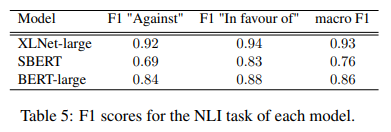

The best macro F1 score is 0.93 reached by XLNet-large, which also has the best F1 for each class. BERT-large has the second-best performance, while SBERT is the worst model. By looking at each class, we can notice that the class "against" has consistently worse F1 scores than the class "in favour of": this difference can be explained by the unbalanced distribution of the two classes, as explained in paragraph 2. In particular, this difference is remarkable for SBERT, where the difference between the F1 scores of the two classes is the highest (14%), while for the other two models is little (4% for BERT-large and 2% for XLNet-large).

### Against

The F1 for 'against' class in SBERT is very low; let's see if the class depends on some labels:

In [58]:
models_results = pd.read_csv('Human-Values-Detection/csv/NLI_results.csv')
sbert = models_results[['Premise', 'Conclusion', 'Stance', 'SBERTPredictions']]
labels_vs_against = pd.concat([sbert, y_val[y_val.columns[1:]]], axis=1) # append the labels dataset to the results dataset

# find the number of targets (in %), i.e. the distirbution of the labels when the model identifies correctly the 'against' class
correct = labels_vs_against[(labels_vs_against['Stance']=='against')&(labels_vs_against['Stance']==labels_vs_against['SBERTPredictions'])]
wrong = labels_vs_against[(labels_vs_against['Stance']=='against')&(labels_vs_against['Stance']!=labels_vs_against['SBERTPredictions'])]
denominator = np.sum(r[y_val.columns[1:]].values)
for i in y_val.columns[1:]:
  correct_percent = sum(correct[i])/denominator*100
  wrong_percent = sum(wrong[i])/denominator*100
  tab = '\t\t'
  if len(i)<7: tab = '\t\t\t\t'
  #elif len(i)>=7 and len(i)<20: tab = '\t\t'
  elif len(i)>24: tab='\t'
  elif len(i)>=7 and len(i)<15: tab='\t\t\t'
  print('Class: {0},{1}Difference:  {2}'.format(i, tab, round(correct_percent-wrong_percent,2)))

Class: Self-direction: thought,		Difference:  -0.67
Class: Self-direction: action,		Difference:  2.94
Class: Stimulation,			Difference:  -1.27
Class: Hedonism,			Difference:  -0.13
Class: Achievement,			Difference:  0.4
Class: Power: dominance,		Difference:  0.93
Class: Power: resources,		Difference:  0.13
Class: Face,				Difference:  -0.4
Class: Security: personal,		Difference:  0.93
Class: Security: societal,		Difference:  1.54
Class: Tradition,			Difference:  -0.07
Class: Conformity: rules,		Difference:  0.87
Class: Conformity: interpersonal,	Difference:  0.13
Class: Humility,			Difference:  0.0
Class: Benevolence: caring,		Difference:  1.2
Class: Benevolence: dependability,	Difference:  1.13
Class: Universalism: concern,		Difference:  3.2
Class: Universalism: nature,		Difference:  1.07
Class: Universalism: tolerance,		Difference:  -0.67
Class: Universalism: objectivity,	Difference:  1.6


As we can see, the differences are very low, so the labels don't influence the classes for the SBERT model.<br>
So, let's have a look on the words and semantic:

In [46]:
correct = sbert[(sbert['Stance']=='against')&(sbert['Stance']==sbert['SBERTPredictions'])]
correct.head(15)

,Premise,Conclusion,Stance,SBERTPredictions
5,social media helps in fast dessimination of vi...,social media brings more harm than good.,against,against
10,home schooling is a good alternative for many....,homeschooling should be banned.,against,against
12,homeopathy often gives people hope to cure som...,homeopathy brings more harm than good.,against,against
27,intelligence tests bring more good than harm b...,intelligence tests bring more harm than good.,against,against
30,"celibacy holds many virtues, offers protection...",the vow of celibacy should be abandoned.,against,against
34,social media itself is not the cause of the ne...,social media brings more harm than good.,against,against
38,iq tests allows students to understand and foc...,intelligence tests bring more harm than good.,against,against
41,in the united states of america we believe in ...,holocaust denial should be a criminal offence.,against,against
42,surrogacy allows women to have a child who wou...,surrogacy should be banned.,against,against
51,they hold a very high title to which they agre...,the vow of celibacy should be abandoned.,against,against


In [45]:
wrong = sbert[(sbert['Stance']=='against')&(sbert['Stance']!=sbert['SBERTPredictions'])]
wrong.head(15)

,Premise,Conclusion,Stance,SBERTPredictions
6,referendums weaken the sovereignty of the parl...,referendums are good for the society.,against,in favour of
15,we don't need to subsidize vocational educatio...,we should subsidize vocational education.,against,in favour of
24,it can help give a child from a broken home a ...,foster care brings more harm than good.,against,in favour of
29,holocaust denial should not be a criminal offe...,holocaust denial should be a criminal offence.,against,in favour of
37,hamas is too dangerous to allow in & the block...,blockade of the gaza strip should be ended.,against,in favour of
40,the use of public defenders should not be mand...,the use of public defenders should be mandatory.,against,in favour of
58,a person has their right to their own opinion ...,holocaust denial should be a criminal offence.,against,in favour of
78,many people are dying of hunger in india. hung...,cattle slaughter should be banned.,against,in favour of
91,integrating one non-western immigrant cost ca....,we should sponsor the general population for t...,against,in favour of
101,entrapment is an unjust form of capturing crim...,entrapment should be legalized.,against,in favour of


We can see a significant difference between the correct and incorrect predictions: on the one hand,
SBERT performs well when the conclusions con-
tain terms whose meanings consistently oppose
the premise, such as "abolish", "ban", "harm", and
"abandon". However, when the text includes terms
whose meanings are context-dependent, SBERT’s
performance deteriorates. This suggests that our
SBERT is unable to learn the correct semantics of
these potentially misleading words.<br>
We also note all the considerations for the entire dataset.

In [81]:
xlnet = models_results[['Premise', 'Conclusion', 'Stance', 'XLNetLargePredictions']]
xlnet.iloc[[6,15, 24, 29, 37]] # same behaviour for BERT Large

,Premise,Conclusion,Stance,XLNetLargePredictions
6,referendums weaken the sovereignty of the parl...,referendums are good for the society.,against,against
15,we don't need to subsidize vocational educatio...,we should subsidize vocational education.,against,against
24,it can help give a child from a broken home a ...,foster care brings more harm than good.,against,against
29,holocaust denial should not be a criminal offe...,holocaust denial should be a criminal offence.,against,against
37,hamas is too dangerous to allow in & the block...,blockade of the gaza strip should be ended.,against,against


 This issue does
not occur for XLNet-large and BERT-large, which
have significantly better F1 scores for the "against"
stance.

### In favour of

In [61]:
wrong = sbert[(sbert['Stance']=='in favour of')&(sbert['Stance']!=sbert['SBERTPredictions'])]
wrong.head(15)

,Premise,Conclusion,Stance,SBERTPredictions
61,social media provides an easy and anonymous wa...,social media brings more harm than good.,in favour of,against
90,social media helps to enable bullying.,social media brings more harm than good.,in favour of,against
95,social media provides an easy way for people t...,social media brings more harm than good.,in favour of,against
99,a surrogate carrying a baby could try to keep ...,surrogacy should be banned.,in favour of,against
165,homeopathy if not used correctly for many ailm...,homeopathy brings more harm than good.,in favour of,against
178,people believe it is helping when it is not.,homeopathy brings more harm than good.,in favour of,against
222,you can get all you need on the internet now.,we should abandon television.,in favour of,against
251,i am not prepared to continue to restrict my f...,we should prevent the surveillance state.,in favour of,against
355,if we are talking about priests then nothing i...,the vow of celibacy should be abandoned.,in favour of,against
369,children have a right to education and ignoran...,homeschooling should be banned.,in favour of,against


Here, we can note that the majority contain the characteristic words of the "against" stance mentioned previously, implying that SBERT
has learned these terms as strictly distinctive to
this category.

Then, let's compare the performace of XLNet Large and BERT Large on this class:

In [74]:
xlnet.iloc[[147, 222, 378, 1776, 1393]]

,Premise,Conclusion,Stance,XLNetLargePredictions
147,"yes, you need to make workers aware of what th...",payday loans should be banned.,in favour of,in favour of
222,you can get all you need on the internet now.,we should abandon television.,in favour of,in favour of
378,all the countries do not have very high securi...,nuclear disarmament is necessary.,in favour of,in favour of
1776,wind and solar power sources are inherently no...,we should invest in nuclear energy.,in favour of,in favour of
1393,according to bbc: 'bitcoin uses more electrici...,we should prohibit certain energy-intensive cr...,in favour of,in favour of


In [75]:
bert = models_results[['Premise', 'Conclusion', 'Stance', 'BERTLargePredictions']]
bert.iloc[[147, 222, 378, 1776, 1393]]

,Premise,Conclusion,Stance,BERTLargePredictions
147,"yes, you need to make workers aware of what th...",payday loans should be banned.,in favour of,against
222,you can get all you need on the internet now.,we should abandon television.,in favour of,against
378,all the countries do not have very high securi...,nuclear disarmament is necessary.,in favour of,against
1776,wind and solar power sources are inherently no...,we should invest in nuclear energy.,in favour of,against
1393,according to bbc: 'bitcoin uses more electrici...,we should prohibit certain energy-intensive cr...,in favour of,against


In [80]:
wrong = xlnet[(xlnet['Stance']=='in favour of')&(xlnet['Stance']!=xlnet['XLNetLargePredictions'])]
wrong.head(5)

,Premise,Conclusion,Stance,XLNetLargePredictions
14,"in the uk since 2015, there were over 80 pv-re...",we should promote the use of nuclear energy in...,in favour of,against
43,"'people highlight various risks, but any gener...",we should promote the use of nuclear energy in...,in favour of,against
47,while it is only promoted/suggested and not a ...,we should promote a plant-based diet.,in favour of,against
48,dna has got nothing to do with spirituality. i...,human gene editing is a good thing.,in favour of,against
75,even if you are convicted of a crime because o...,entrapment should be legalized.,in favour of,against


# Bibliography and sitography
- Original Paper for the Project: [Human Values Detection task for the SemEval 2023](https://touche.webis.de/semeval23/touche23-web/index.html)
- Link to Dataset: https://zenodo.org/record/7402070#.Y7VgzC9aZQJ
- XLNet-Large model: https://huggingface.co/xlnet-large-cased
- Reset Layers Weights: [On Stability of Few-Sample Transformer Fine-Tuning, CommonLit Readability Prize](https://www.kaggle.com/code/rhtsingh/on-stability-of-few-sample-transformer-fine-tuning)

# GitHub Repository
You can find the PDF, the notebook and the report on: https://github.com/DitucSpa/Human-Values-Detection